Changed working directory to: c:\Users\piopi\Desktop\Projet_EI_ST4\Forecast-of-Electricity-Consumption
Validation RMSE (last 30 days): 2.52 kWh
Validation MAE (last 30 days): 1.91 kWh


c:\Users\piopi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


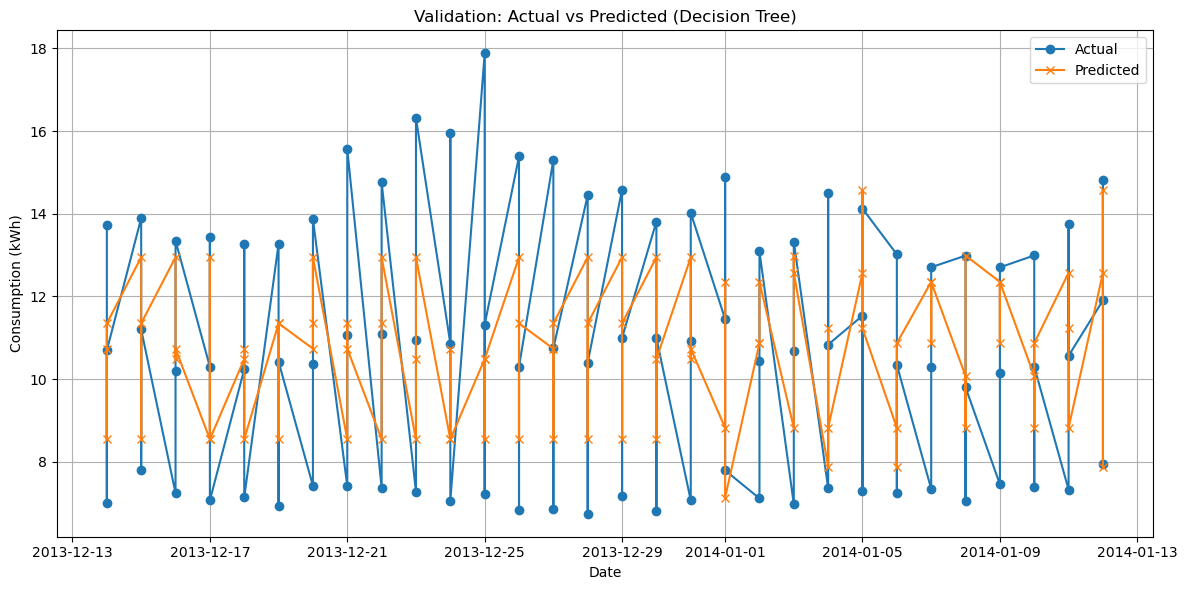

No data available for the requested forecast period (2014-01-13 to 2014-02-13). Only validation results are shown.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Change working directory if needed
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

# Load daily data
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')

# Load holidays
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')
holiday_dates = set(uk_bank_holidays['Bank holidays'].dt.date)

# Feature engineering
df = group_4_daily.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['IsHoliday'] = df['Date'].dt.date.isin(holiday_dates).astype(int)
df['Lag1'] = df['Conso_kWh'].shift(1)
df['Lag7'] = df['Conso_kWh'].shift(7)
df = df.dropna().reset_index(drop=True)

feature_cols = ['Lag1', 'Lag7', 'DayOfWeek', 'Month', 'IsHoliday']
target_col = 'Conso_kWh'

# 1. Validation split (last 30 days of available data)
split_date = df['Date'].max() - pd.Timedelta(days=30)
train = df[df['Date'] <= split_date]
val = df[df['Date'] > split_date]

X_train = train[feature_cols]
y_train = train[target_col]
X_val = val[feature_cols]
y_val = val[target_col]

# 2. Train and evaluate
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation RMSE (last 30 days): {val_rmse:.2f} kWh")
print(f"Validation MAE (last 30 days): {val_mae:.2f} kWh")

# 3. Plot validation results
plt.figure(figsize=(12, 6))
plt.plot(val['Date'], y_val.values, label='Actual', marker='o')
plt.plot(val['Date'], y_val_pred, label='Predicted', marker='x')
plt.title('Validation: Actual vs Predicted (Decision Tree)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 4. Retrain on all data before requested forecast period and predict for requested period
test_start = pd.Timestamp('2014-01-13')
test_end = pd.Timestamp('2014-02-13')

train_full = df[df['Date'] < test_start]
test_period = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]

X_train_full = train_full[feature_cols]
y_train_full = train_full[target_col]
X_test = test_period[feature_cols]
y_test = test_period[target_col]

model.fit(X_train_full, y_train_full)
if not X_test.empty:
    y_test_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Test RMSE (forecast period): {test_rmse:.2f} kWh")
    print(f"Test MAE (forecast period): {test_mae:.2f} kWh")

    # 5. Plot forecast for requested period
    plt.figure(figsize=(12, 6))
    plt.plot(test_period['Date'], y_test.values, label='Actual', marker='o')
    plt.plot(test_period['Date'], y_test_pred, label='Predicted', marker='x')
    plt.title('Forecast Period: Actual vs Predicted (Decision Tree)')
    plt.xlabel('Date')
    plt.ylabel('Consumption (kWh)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    print("No data available for the requested forecast period (2014-01-13 to 2014-02-13). Only validation results are shown.")